In [2]:
import random,os,csv,glob,math,logging
import json
import numpy as np
import pandas as pd
import time

import cv2 as cv
from sklearn.manifold import TSNE
import scipy.io as sio
from os.path import dirname, join as pjoin
import scipy.io as sio
import pickle as pk

from matplotlib import pyplot as plt
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Concatenate,LeakyReLU,Input, Dropout,Lambda,Activation, BatchNormalization
from tensorflow.keras.layers import MaxPooling1D,Conv1D,GlobalAveragePooling1D,multiply
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import models, layers, optimizers  
from tensorflow.keras.callbacks import TensorBoard  
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import MinMaxScaler
import sys
import gzip
os.environ["CUDA_VISIBLE_DEVICES"]="0"
mod = sys.modules[__name__]
scaler = MinMaxScaler()

In [3]:
def plot_embedding(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    for i in tqdm.tqdm(range(X.shape[0])):
        # plot colored number
        if d[i] == 0:
            color = 'green'
        elif d[i] == 1:
            color = 'purple'
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=color,
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='float32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='float32')
# Process MNIST
mnist_train = (x_train > 0).reshape(60000, 28, 28, 1).astype(np.uint8) * 255
mnist_train = mnist_train[:10000]
trainX = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
mnist_test = (x_test > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test = mnist_test[:500]
testX = np.concatenate([mnist_test, mnist_test, mnist_test], 3)

# Load MNIST-M dataset as out-of-domain and unlabeled data
with open('mnistm_data.pkl', 'rb') as f:
	mnistm = pk.load(f)
trainDX = mnistm['train'][:10000]
testDX = mnistm['test'][:500]

trainY = y_train[:10000]
testY = y_test[:500]
# Rescale -1 to 1
trainX = trainX.astype(np.float32)/255.
trainDX = trainDX.astype(np.float32)/255.
testX = testX.astype(np.float32)/255.
testDX = testDX.astype(np.float32)/255.

trainX_domain = np.tile([1., 0.], [len(trainX), 1])
trainDX_domain = np.tile([0., 1.], [len(trainDX),1])

testX_domain = np.tile([1., 0.], [len(testX), 1])
testDX_domain = np.tile([0., 1.], [len(testDX),1])

print(trainX.shape,trainDX.shape,testX.shape,testDX.shape)

combined_train_imgs = np.concatenate([trainX, trainDX])
combined_train_labels = np.concatenate([trainY, trainY])
combined_train_domain = np.concatenate([np.tile([1., 0.], [len(trainX), 1]),
                                        np.tile([0., 1.], [len(trainDX), 1])])
print(combined_train_imgs.shape,combined_train_labels.shape,combined_train_domain.shape)

combined_test_imgs = np.concatenate([testX, testDX])
combined_test_labels = np.concatenate([testY, testY])
combined_test_domain = np.concatenate([np.tile([1., 0.], [len(testX), 1]),
                                        np.tile([0., 1.], [len(testDX), 1])])

print(combined_test_imgs.shape,combined_test_labels.shape,combined_test_domain.shape)

(10000, 28, 28, 3) (10000, 28, 28, 3) (500, 28, 28, 3) (500, 28, 28, 3)
(20000, 28, 28, 3) (20000, 10) (20000, 2)
(1000, 28, 28, 3) (1000, 10) (1000, 2)


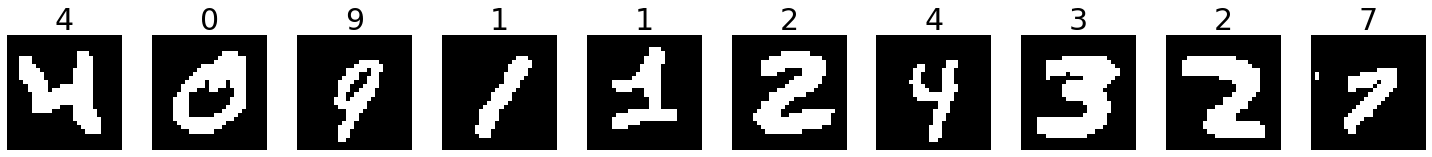

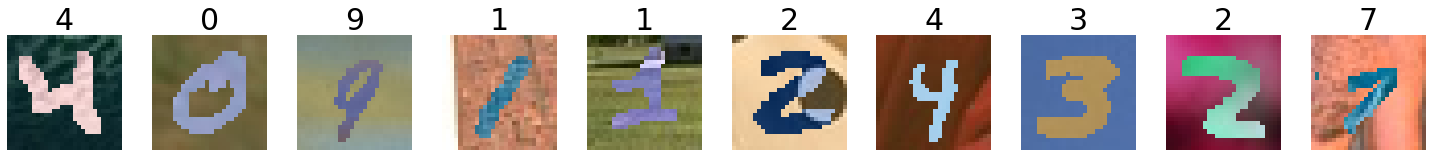

In [21]:
c=0
plt.figure(figsize=(20,3))
for i in range(20,30):
    plt.subplot(1,10,c+1)
    plt.imshow(trainX[i])
    plt.title(trainY[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()
plt.figure(figsize=(20,3))
c=0
for i in range(20,30):
    plt.subplot(1,10,c+1)
    plt.imshow(trainDX[i])
    plt.title(trainY[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1

In [45]:
@tf.custom_gradient
def GradientReversalOperator(x):
	def grad(dy):
		return -1 * dy
	return x, grad

class GradientReversalLayer(tf.keras.layers.Layer):
	def __init__(self):
		super(GradientReversalLayer, self).__init__()
		
	def call(self, inputs):
		return GradientReversalOperator(inputs)

def feature_extractor(inp):
    ''' 
    This function defines the structure of the feature extractor part.
    '''
    out = Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation="relu")(inp)
    out = MaxPooling2D(pool_size=(2, 2))(out)

    out = Conv2D(filters=48, kernel_size=(5, 5), padding="same", activation="relu")(out)
    out = MaxPooling2D(pool_size=(2, 2))(out)
    feature_output = Flatten(name='feature')(out)
    return feature_output

def classifier(inp):
    ''' 
    This function defines the structure of the classifier part.
    '''
    out = Dense(100, activation="relu")(inp)
    out = Dense(64, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(10, activation="softmax", name="classifier_output")(out)
    return classifier_output

def discriminator(inp):
    ''' 
    This function defines the structure of the discriminator part.
    '''
    out = Dense(20, activation="relu")(inp)
    discriminator_output = Dense(2, activation="softmax", name="discriminator_output")(out)
    return discriminator_output

def cnn_model():
    inp = Input(shape=(28,28,3), name="main_input")
    feature_output = feature_extractor(inp)
    classifier_output = classifier(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

def dann():    
    inp =  Input(shape=(28,28,3),name="main_input")
    feature_output = feature_extractor(inp)
    classifier_output = classifier(feature_output)

    grl_layer = GradientReversalLayer()(feature_output)
    discriminator_output = discriminator(grl_layer)
    model = tf.keras.models.Model(inputs=inp, outputs=[discriminator_output,classifier_output])
    return model

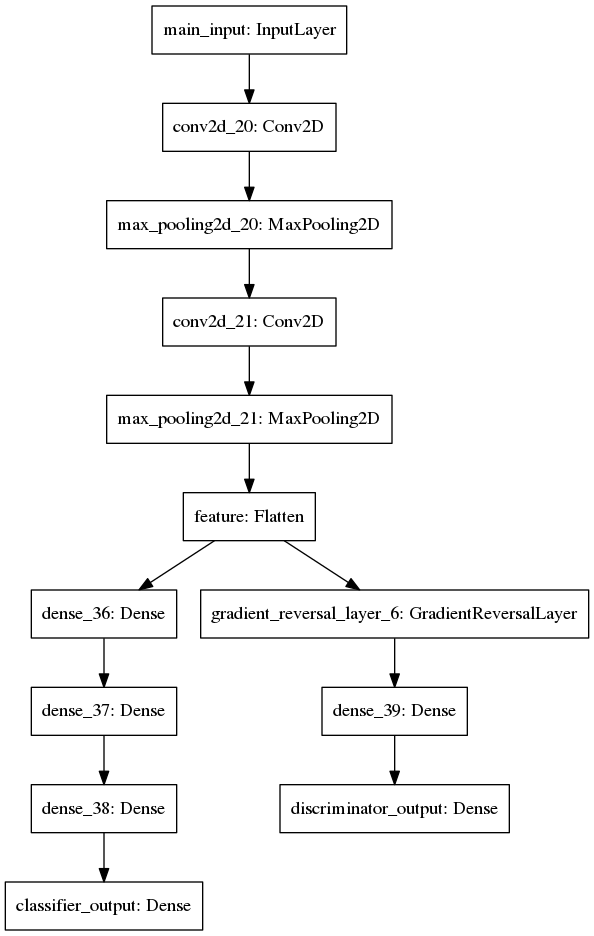

In [36]:
plot_model(dann())

In [37]:
def mape(y_true, y_pred): 
    return K.mean(K.abs((y_true - y_pred) / y_true))*100
    
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape2(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))*100
    
def rmse2(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

def R2(y_true,y_pred):
    SSE = np.mean(np.square(y_true - y_pred))
    SSR = np.mean(np.square(y_true - np.var(y_true)))
    result = 1 - (SSE/SSR)
    return result

model_dir = './model_checkpoint/'
def mkdir(model_dir):
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)

In [38]:
def training(model,model_name,dataset):
    #hyperparameters
    lr= 0.0001
    bata_1= 0.9
    batch_size= 32
    epochs= 100
    patience = 90
    savename =  model_dir+model_name+".h5"

    if 'dann' in model_name:
        cp_callback = ModelCheckpoint(filepath = savename
                                  ,monitor='val_classifier_output_loss'
                                  ,save_best_only=True
                                  ,save_weights_only=True)

        early_stopping = EarlyStopping(monitor='val_classifier_output_loss'
                                  ,patience=patience)
        model.compile(optimizer=Adam(lr=lr)
                      ,loss={'classifier_output': 'categorical_crossentropy'
                             ,'discriminator_output': 'binary_crossentropy'})
    else:
        cp_callback = ModelCheckpoint(filepath = savename
                                  ,monitor='val_loss'
                                  ,save_best_only=True
                                  ,save_weights_only=True)

        early_stopping = EarlyStopping(monitor='val_loss'
                                  ,patience=patience)
        model.compile(optimizer=Adam(lr=lr)
                      ,loss={'classifier_output': 'categorical_crossentropy'})
        
    startTime = time.time()

    #x_train,y_train = combined_train_imgs,combined_train_labels
    x_train,y_train,x_valid,y_valid = dataset
    #x_valid,y_valid = combined_test_imgs,combined_test_labels

    hist = model.fit(x_train,y_train
                  ,batch_size=batch_size
                  ,epochs= epochs
                  ,verbose= 0
                  ,validation_data =(x_valid,y_valid)
                  ,callbacks=[cp_callback, early_stopping])

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    endTime = time.time() - startTime
    print("end time:",round(endTime,2))

end time: 175.74


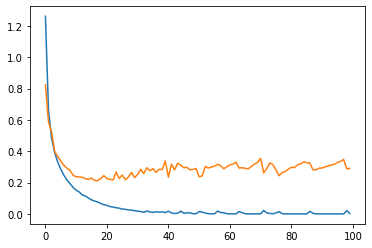

In [39]:
model_name = 'cnn_minst'
dataset = (combined_train_imgs,combined_train_labels
          ,combined_test_imgs,combined_test_labels)
training(cnn_model(),model_name,dataset)

end time: 228.93


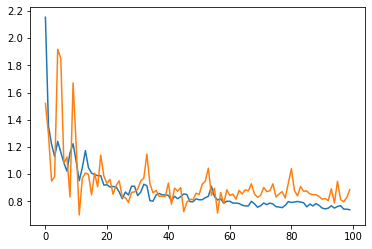

In [46]:
model_name = 'dann_mnist'
dataset = (combined_train_imgs,[combined_train_domain,combined_train_labels]
          ,combined_test_imgs,[combined_test_domain,combined_test_labels])
training(dann(),model_name,dataset)

In [47]:
cnn = cnn_model()
cnn.load_weights('./model_checkpoint/cnn_minst.h5')

dann = dann()
dann.load_weights('./model_checkpoint/dann_mnist.h5')

In [42]:
cnn.compile(optimizer=Adam(lr=0.0001)
                      ,loss={'classifier_output': 'categorical_crossentropy'}
                      ,metrics = {'classifier_output':'acc'})
source_acc = cnn.evaluate(testX,testY)
target_acc = cnn.evaluate(testDX,testY)
print('source acc:',round(source_acc[-1]*100,5),'%')
print('target acc:',round(target_acc[-1]*100,5),'%')

16/16 [==============================] - 0s 3ms/step - loss: 0.3636 - acc: 0.8760
source acc: 98.2 %
target acc: 87.6 %


In [48]:
dann.compile(optimizer=Adam(lr=0.0001)
                      ,loss={'classifier_output': 'categorical_crossentropy'
                             ,'discriminator_output': 'binary_crossentropy'}
                      ,metrics = {'classifier_output':'acc',
                                  'discriminator_output': 'acc'})
source_acc = dann.evaluate(testX,[testX_domain,testY])
target_acc = dann.evaluate(testDX,[testDX_domain,testY])
print('source acc:',round(source_acc[-1]*100,5),'%')
print('target acc:',round(target_acc[-1]*100,5),'%')

16/16 [==============================] - 0s 4ms/step - loss: 0.9523 - discriminator_output_loss: 0.7204 - classifier_output_loss: 0.2319 - discriminator_output_acc: 0.4520 - classifier_output_acc: 0.9300
source acc: 97.8 %
target acc: 93.0 %


100%|██████████| 1000/1000 [00:00<00:00, 2503.36it/s]


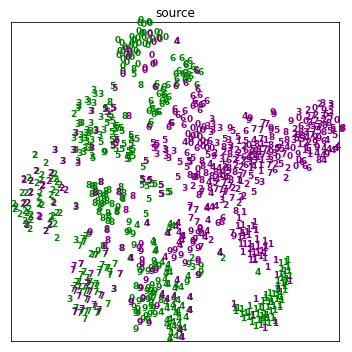

In [49]:
feature_model = Model(cnn.input,cnn.get_layer('feature').output)
emb = feature_model.predict(combined_test_imgs)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
source_only_tsne = tsne.fit_transform(emb)
plot_embedding(source_only_tsne, combined_test_labels.argmax(1)
               ,combined_test_domain.argmax(1),'source')

100%|██████████| 1000/1000 [00:00<00:00, 2927.69it/s]


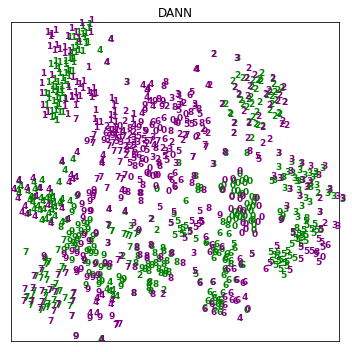

In [50]:
feature_model = Model(dann.input,dann.get_layer('feature').output)
emb = feature_model.predict(combined_test_imgs)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
source_only_tsne = tsne.fit_transform(emb)
plot_embedding(source_only_tsne, combined_test_labels.argmax(1)
               ,combined_test_domain.argmax(1),'DANN')